In [1]:
from threading import Thread
import time
import os

In [2]:
import rospy
import actionlib
from assignment_2_2022.msg import PlanningAction, PlanningGoal
from unige_rt1_assignment2.srv import GoalInfo
from unige_rt1_assignment2.msg import RoboStatusMsg
from sensor_msgs.msg import LaserScan

from nav_msgs.msg import Odometry

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.core.display import HTML
from ipywidgets import Layout

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import tf
from tf.transformations import quaternion_matrix
import numpy as np

%matplotlib widget

Plotting Class

In [5]:
class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln

    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        self.fig.canvas.draw()
        return self.ln

In [6]:
class RoboClient:
    def __init__(self):
        rospy.init_node('robo_client', anonymous=True)
        
        # Service client to get the goals info
        self.goal_info_client = rospy.ServiceProxy("/goals_service", GoalInfo)

        # Dictionary to store the robot position
        self. robo_position = {
            "x": 0.0,
            "y": 0.0
        }
        # Subscriber to get the robot position
        self.robo_position_sub = rospy.Subscriber("/robot/robo_stats", RoboStatusMsg, self.robo_position_callback)

        # variable to store the closest obstacle, defined as infinity at the beginning
        self.closest_obstacle = float("inf")
        # Subscriber to get the laser scan information for distance to obstacles
        self.laser_scan_sub = rospy.Subscriber("/scan", LaserScan, self.laser_scan_callback)

        # Action client to send the goals
        self.target_ac = actionlib.SimpleActionClient("/reaching_goal", PlanningAction)
        rospy.loginfo("Waiting for action server to start.")
        self.target_ac.wait_for_server()
        rospy.loginfo("Action server started!")

        # Initialize the Visualizer
        self.vis = Visualiser()
        self.vis_sub = rospy.Subscriber("/odom", Odometry, self.vis.odom_callback)
        self.vis_ani = FuncAnimation(self.vis.fig, self.vis.update_plot, init_func=self.vis.plot_init, cache_frame_data=False)

    def send_goal(self, x, y):
        goal = PlanningGoal()
        goal.target_pose.pose.position.x = x
        goal.target_pose.pose.position.y = y
        self.target_ac.send_goal(goal)

        if rospy.has_param("/robot/goal_pos_param"):
            rospy.set_param("/robot/goal_pos_param/x_goal", x)
            rospy.set_param("/robot/goal_pos_param/y_goal", y)
        else:
            rospy.logerr("Goal position parameter not found on the parameter server.")

    def cancel_goal(self):
        if self.target_ac.get_state() == actionlib.GoalStatus.ACTIVE:
            print("Cancelling current goal...")
            self.target_ac.cancel_goal()
        else:
            print("No goal is currently executing.")
    
    def get_goal_info(self):
        try:
            goals_info_response = self.goal_info_client()
            return goals_info_response.msg_feedback
        except rospy.ServiceException as e:
            print("Service call failed: %s"%e)
            return None

    def robo_position_callback(self, msg):
        self.robo_position["x"] = msg.pos_x
        self.robo_position["y"] = msg.pos_y
    
    def get_robo_position(self):
        return self.robo_position["x"], self.robo_position["y"]

    def laser_scan_callback(self, msg):
        self.closest_obstacle = min(msg.ranges)

    def get_closest_obstacle(self):
        return self.closest_obstacle

    def spin(self):
        rospy.spin()

[INFO] [1684080346.976152, 2224.436000]: Waiting for action server to start.
[INFO] [1684080347.008852, 2224.465000]: Action server started!


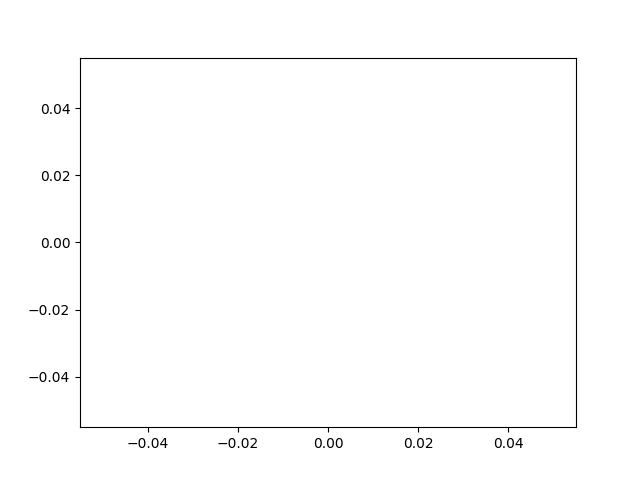

Sending new goal: (2.0, -2.0)
Sending new goal: (2.0, -5.0)
Cancelling current goal...


In [7]:
robo_client = RoboClient()

def on_send_button_click(button):
    x = float(x_text.value)
    y = float(y_text.value)
    robo_client.send_goal(x, y)
    print(f"Sending new goal: ({x}, {y})")

def on_cancel_button_click(button):
    robo_client.cancel_goal()

x_text = widgets.FloatText(description="X:")
y_text = widgets.FloatText(description="Y:")

send_button = widgets.Button(description="Send Goal")
send_button.on_click(on_send_button_click)

cancel_button = widgets.Button(description="Cancel Goal")
cancel_button.on_click(on_cancel_button_click)

goal_ui = widgets.HBox([x_text, y_text, send_button, cancel_button])

In [8]:
# Information Display UI

# Widget to display the robot position
robo_pos_widget_label = widgets.HTML(value="<p style='font-size: 14px;'><b>Robot position:</b> N/A</p>")

# Widget to display the closest obstacle
closest_obstacle_widget_label = widgets.HTML(value="<p style='font-size: 14px;'><b>Distance to closest obstacle:</b> N/A</p>")

# Jupyter widget for goals reached and cancelled
goal_info_widget_label = widgets.HTML(value="<p style='font-size: 14px;'><b>Goals reached:</b> N/A</p>")

# Combine the labels into a single UI using a VBox
info_ui = widgets.VBox([robo_pos_widget_label, closest_obstacle_widget_label, goal_info_widget_label])

In [9]:
# heading
heading = widgets.HTML(value="<center><h2><u>Robot Controller Interface</u></h2></center>")

# Combine the goal UI and the information UI into a single UI using a VBox
combined_ui = widgets.VBox([heading, goal_ui, info_ui])

# Display the combined UI
display(combined_ui)

In [10]:
def updated_robo_position():
    while not rospy.is_shutdown():
        robo_x_pos, robo_y_pos = robo_client.get_robo_position()
        robo_pos_widget_label.value = f"Robot position: ({robo_x_pos:.2f}, {robo_y_pos:.2f})"

        closest_obstacle_dist = robo_client.get_closest_obstacle()
        closest_obstacle_widget_label.value = f"Distance to closest obstacle: {closest_obstacle_dist:.2f}"

        rospy.sleep(0.75)

position_thread = Thread(target=updated_robo_position)
position_thread.start()

In [11]:
def update_goal_info():
    while not rospy.is_shutdown():
        goal_info = robo_client.get_goal_info()
        if goal_info is not None:
            goal_info_widget_label.value = f"Goals Information: {goal_info}"
        rospy.sleep(0.75)

goal_info_thread = Thread(target=update_goal_info)
goal_info_thread.start()